In [ ]:
"""
Job folder output
./1
../activonly
.../pred_label_gtxpy
..../
"""

In [2]:
#list dir for all the log files 
import glob
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import numpy as np
import json

def getkey_gtfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+4] 
    return int(gt[-2:-1])

def getkey_pfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+2] 
    x = f.find('pred_label')
    if gt == '5p':
        return 5
    return int(gt)


met = ['AP-' + cat for cat in ['chair', 'cushion', 'indoor-plant', 'door', 'table', 'sofa']]
met.insert(0, 'AP')

def read_all_results(logf, key_fn):
    with open(logf) as f:
        lines = f.readlines()
    def extract_dicts(lines):
        # start with {"bbox", find index where bracket ob is 0 
        ds = []
#         print(len(lines[0]))
        l = lines[0]
        ob = 0
        s = 0
        e = 0
        for i in range(len(l)):
            if l[i] == '{':
                ob += 1
            elif l[i] == '}':
                ob -= 1
            if ob == 0:
                e = i
#                 print(f'found dict {l[s:e+1]}\n')
                ds.append(l[s:e+1])
                s = i+1
#         print(f'len ds {len(ds)}')
        return ds

    ds = extract_dicts(lines)
    
    bbox = defaultdict(list)
    segm = defaultdict(list)
    
    for d in ds:
        try:
            dj = json.loads(d)
            for k in met:
                bbox[k].append(dj['bbox'][k])
                segm[k].append(dj['segm'][k])
        except:
            pass
#             print(f'json.loads exception, skipping {logf, dj}')
    
    for k, v in bbox.items():
        bbox[k] = np.mean(v)
    
    for k, v in segm.items():
        segm[k] = np.mean(v)
    
    return bbox, segm

def compare(log_act, log_def, key_fn, fixed_label, x_label, gts, ps, n, pref):
    # Look through n trajectories
    def get_averages(log, gts, ps, key_fn, fixed_label, pref=None):
        bm = defaultdict(lambda: defaultdict(list))
        sm = defaultdict(lambda: defaultdict(list))
        for traj in range(n):
            traj_root = os.path.join(log, str(traj))
            if pref:
                traj_root = os.path.join(traj_root, pref)
#             print(f'traj {traj_root}')
            if os.path.isdir(traj_root):
                for gt in gts:
                    for p in ps:
                        outdir = os.path.join(traj_root, f'pred_label_gt{gt}p{p}')
                        if os.path.isfile(os.path.join(outdir, 'all_results.txt')):
                            # read all_results.txt and calculate, bm, sm, and bm1...bm6, sm1...sm6
                            _bm, _sm = read_all_results(os.path.join(outdir, 'all_results.txt'), key_fn)
                            
                            # read averages file 
#                             _bm, _sm = read_metrics(os.path.join(outdir, '10_results_averaged.txt'), key_fn)
                            for k, v in _bm.items():
                                bm[k][gt if fixed_label == 'fixed propagation length' else p].append(v)
                                sm[k][gt if fixed_label == 'fixed propagation length' else p].append(v)
        
        bm_avg = defaultdict(lambda: defaultdict(int))
        sm_avg = defaultdict(lambda: defaultdict(int))
        for k, v in bm.items():
            for l, ap in v.items():
                bm_avg[k][l] = np.mean(ap)
#                 print(k, l, ap)
#             bm_avg[k] = np.mean(v)
        for k, v in sm.items():
            for l, ap in v.items():
                sm_avg[k][l] = np.mean(ap)
                
        for k, v in bm_avg.items():
            bm_avg[k] = dict(sorted(v.items()))
            
        for k, v in sm_avg.items():
            sm_avg[k] = dict(sorted(v.items()))
            
        return dict(sorted(bm_avg.items())), dict(sorted(sm_avg.items()))
    
    
    try:
        bm_act, sm_act = get_averages(log_act, gts, ps, key_fn, fixed_label, pref)
        bm_def, sm_def = get_averages(log_def, gts, ps, key_fn, fixed_label)
        
#         print(type(bm_act), bm_act)
        # Now plot, each key in met
        fig, ax = plt.subplots(2, 7, figsize=(20,10)) # col 1 for bbox, col2 for segm

        for i in range(2):
            for k in range(7):
                ax[i,k].set_xlabel(x_label)
                ax[i,k].set_xlabel('AP')
                if i == 0: # draw bbox
                    ax[i,k].set_title('bbox '+ met[k])
                    ax[i,k].errorbar(bm_act[met[k]].keys(), bm_act[met[k]].values(), label='active')
                    ax[i,k].errorbar(bm_def[met[k]].keys(), bm_def[met[k]].values(), label='baseline')
                elif i == 1: # draw segm
                    ax[i,k].set_title('segm '+ met[k])
                    ax[i,k].errorbar(sm_act[met[k]].keys(), sm_act[met[k]].values(), label='active')
                    ax[i,k].errorbar(sm_def[met[k]].keys(), sm_def[met[k]].values(), label='baseline')
                ax[i,k].legend(loc="upper left")
                
    except:
#         print(bm_act)
        raise
    
    fig.suptitle(fixed_label)
    plt.show()

default, p 2


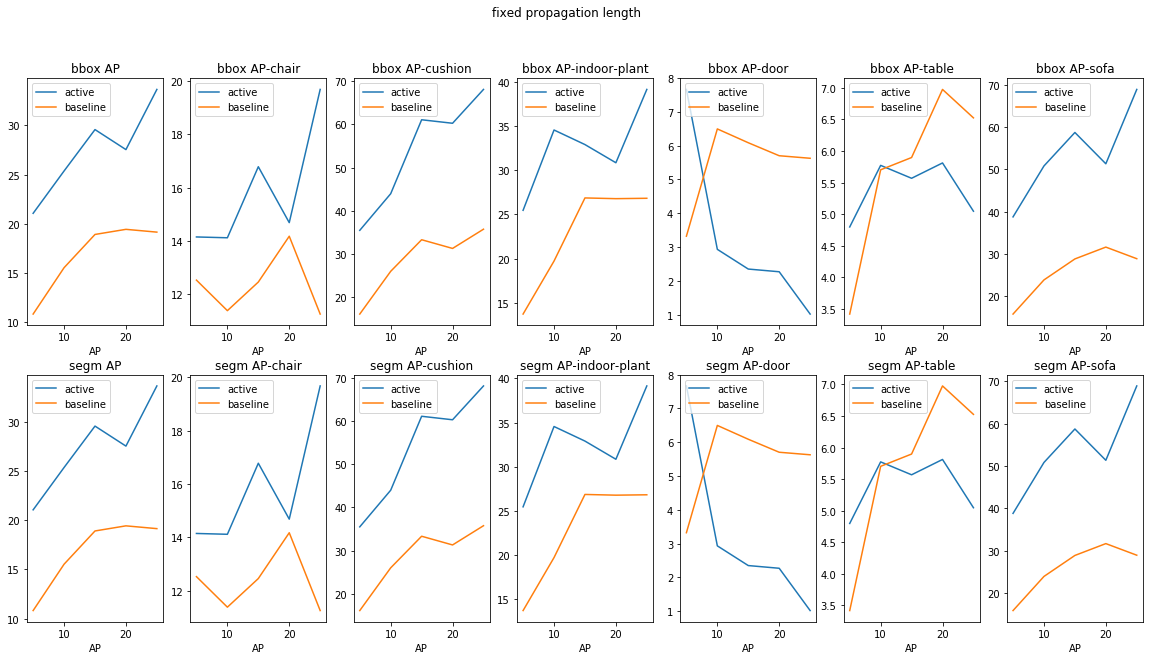

default, p 4


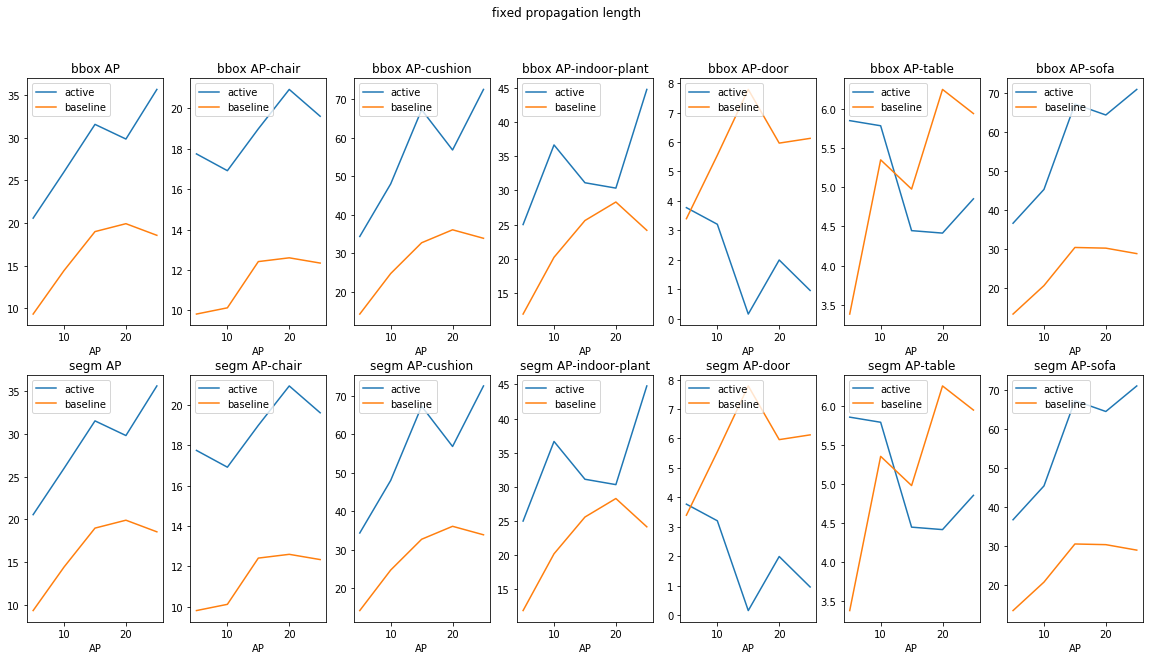

default, p 6


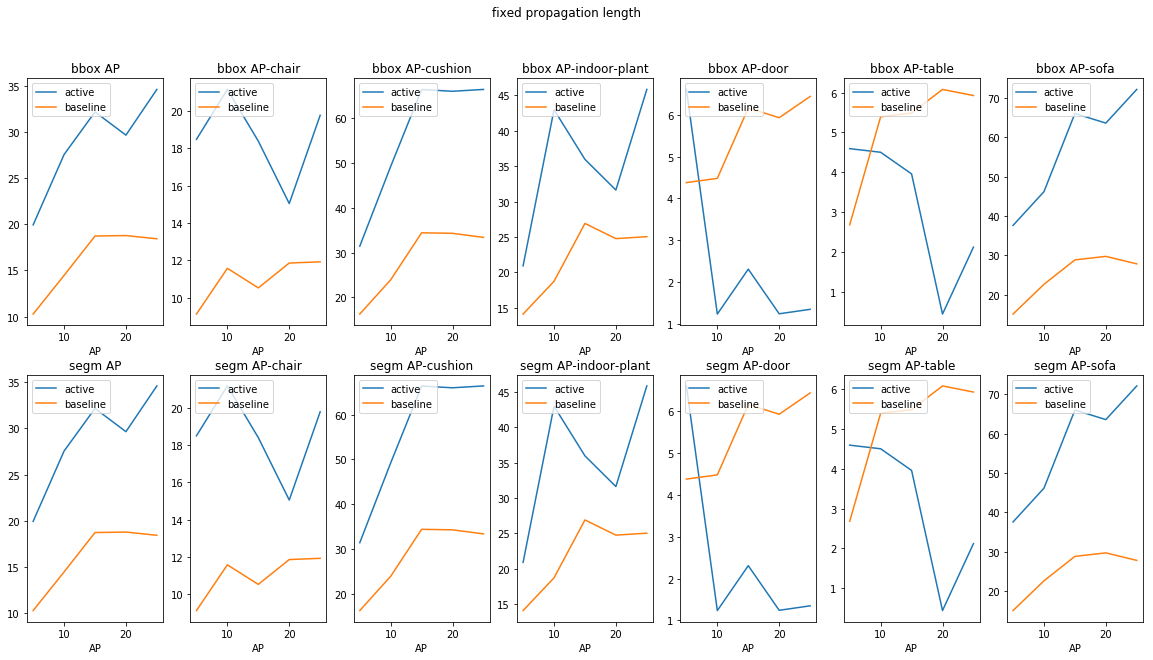

default, p 8


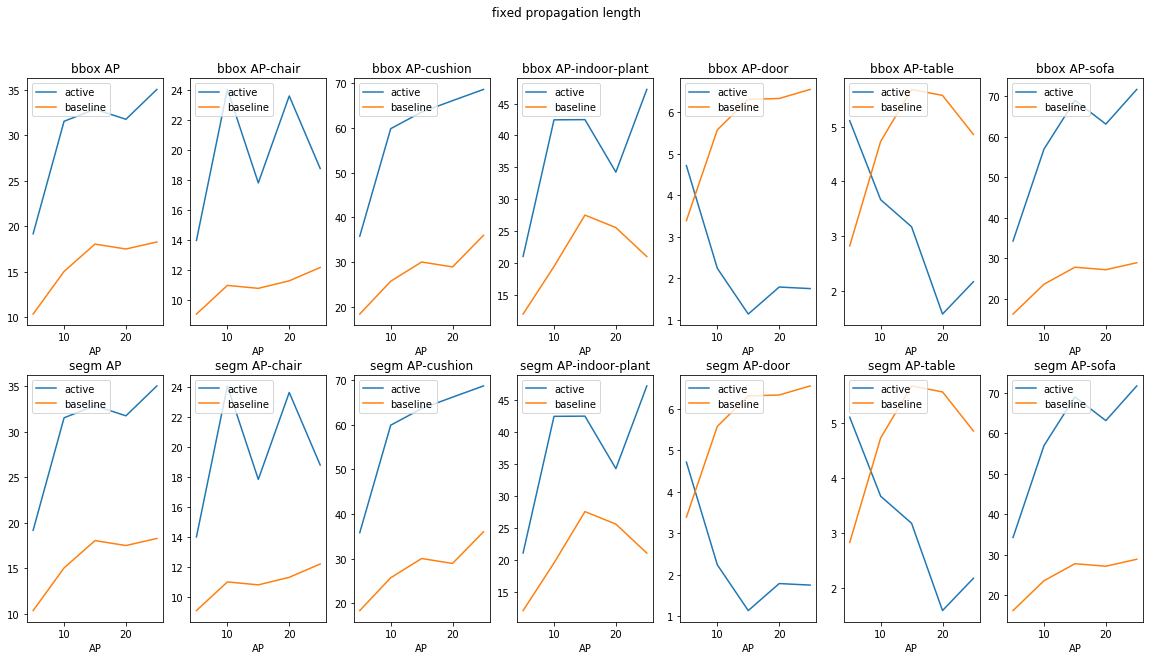

default, gt 5


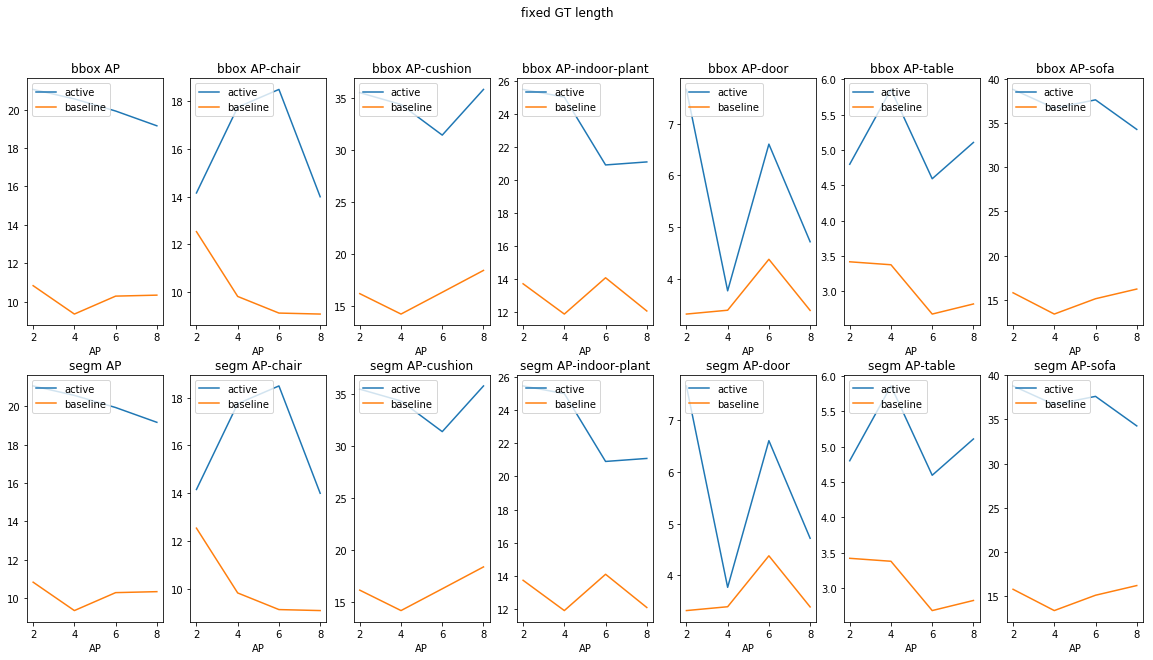

default, gt 10


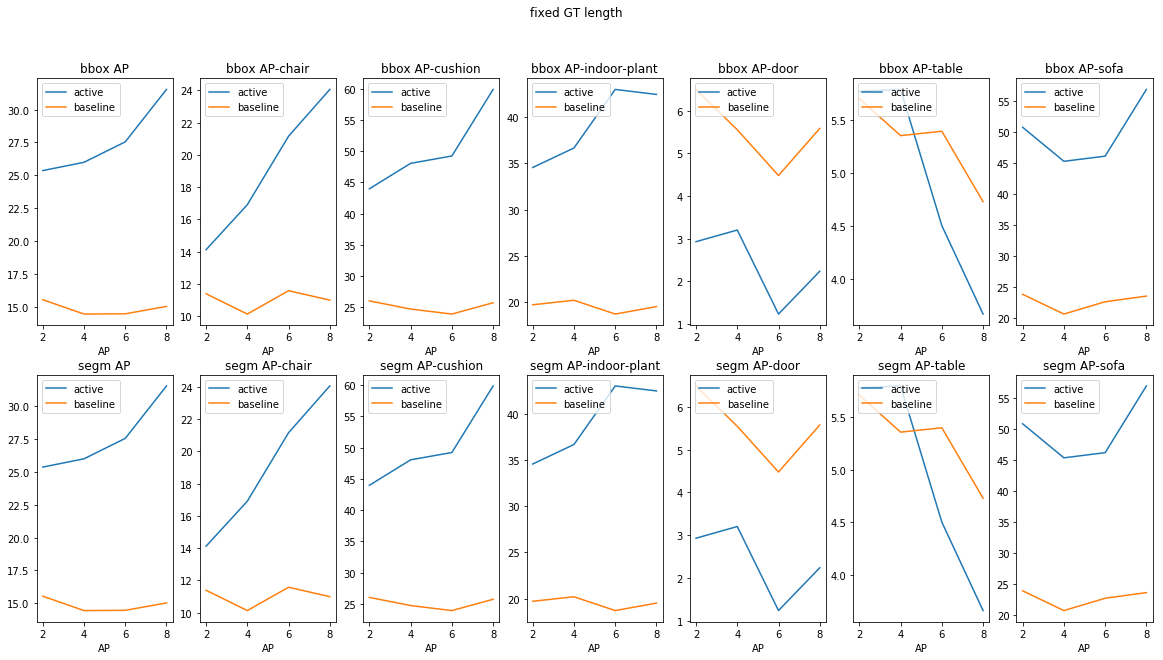

default, gt 15


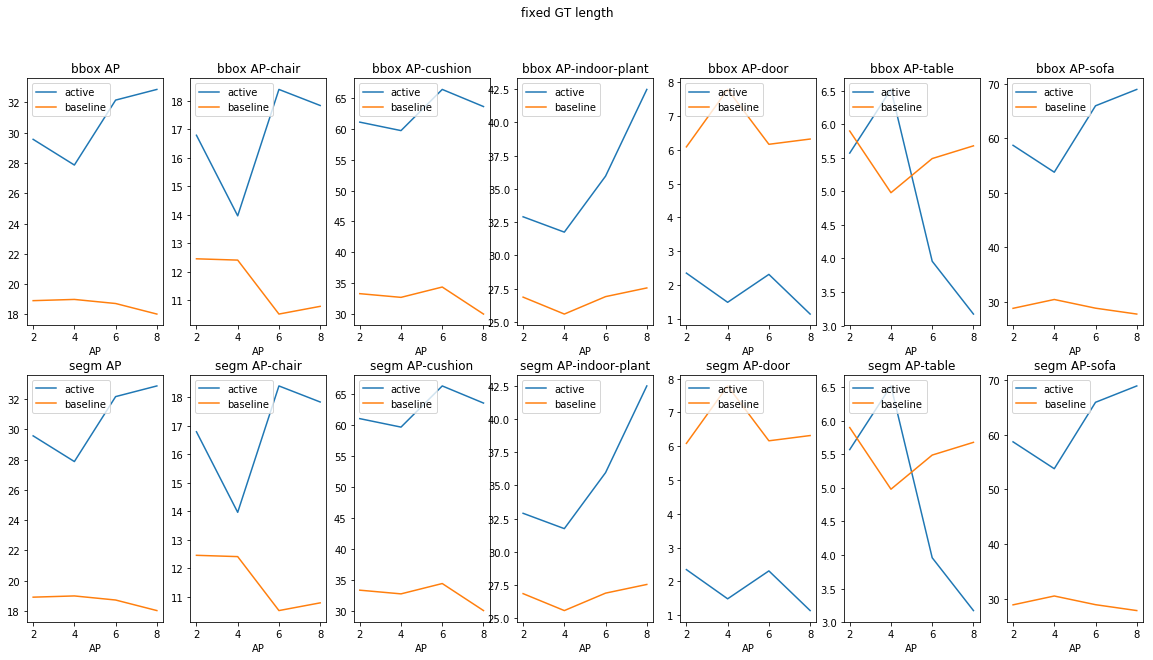

default, gt 20


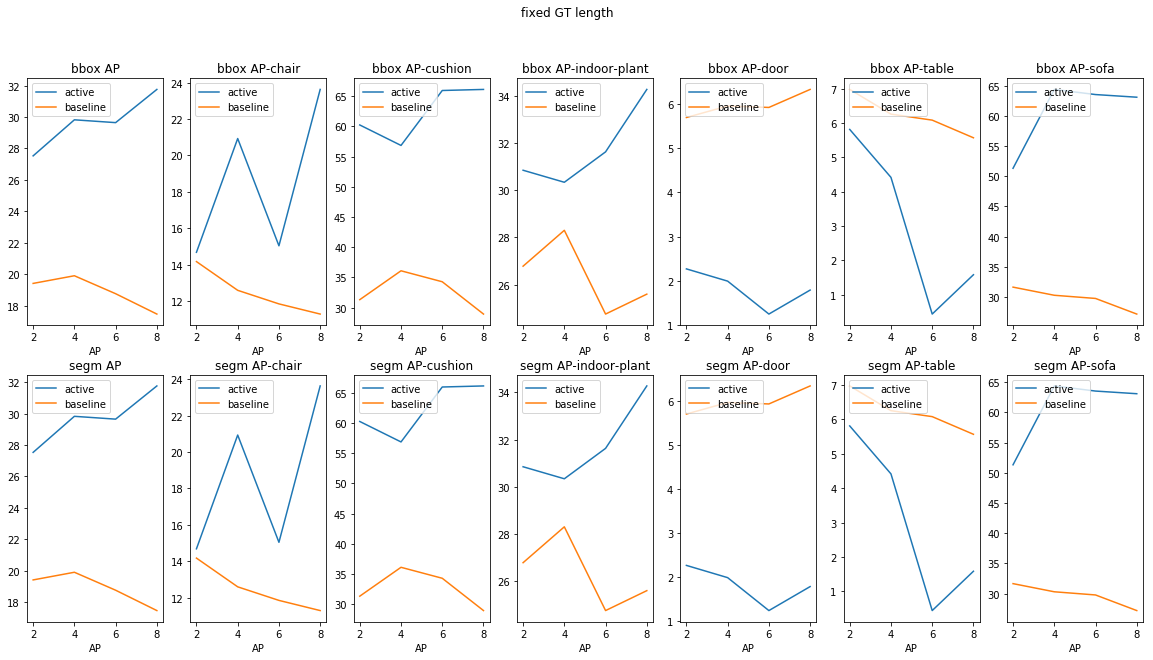

default, gt 25


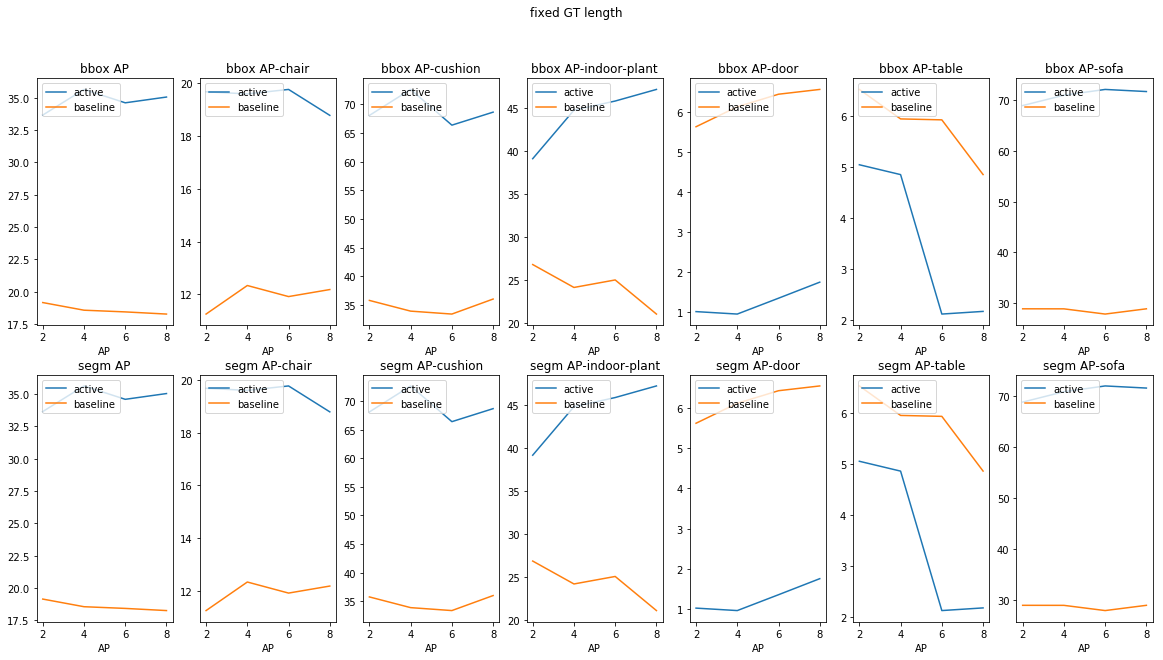

In [5]:
for pref in ['default']:
    for p in [2, 4, 6, 8]:
        print(f'{pref}, p {p}')
        compare(
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-10-2021/00:13:12',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/14-10-2021/19:17:17',
#             '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-10-2021/14:31:00',
            '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43',
            '/checkpoint/kavyasrinet/jobs/active_vision/pipeline/apartment_0/default/no_noise/15-10-2021/15:21:23',
#             '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-09-2021/02:35:54',
            getkey_pfix,
            'fixed propagation length',
            '#GT Frames',
            gts=[5,10,15,20,25],
            ps=[p],
            n=20,
            pref=pref
        )
    
for pref in ['default']:
    for gt in [5,10,15,20,25]:
        print(f'{pref}, gt {gt}')
        compare(
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-10-2021/00:13:12',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/14-10-2021/19:17:17',
#             '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-10-2021/14:31:00',
            '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43',
            '/checkpoint/kavyasrinet/jobs/active_vision/pipeline/apartment_0/default/no_noise/15-10-2021/15:21:23',
#             '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-09-2021/02:35:54',
            getkey_gtfix,
            'fixed GT length',
            'Propagation length',
            gts=[gt],
            ps=[2,4,6,8],
            n=20,
            pref=pref
        )

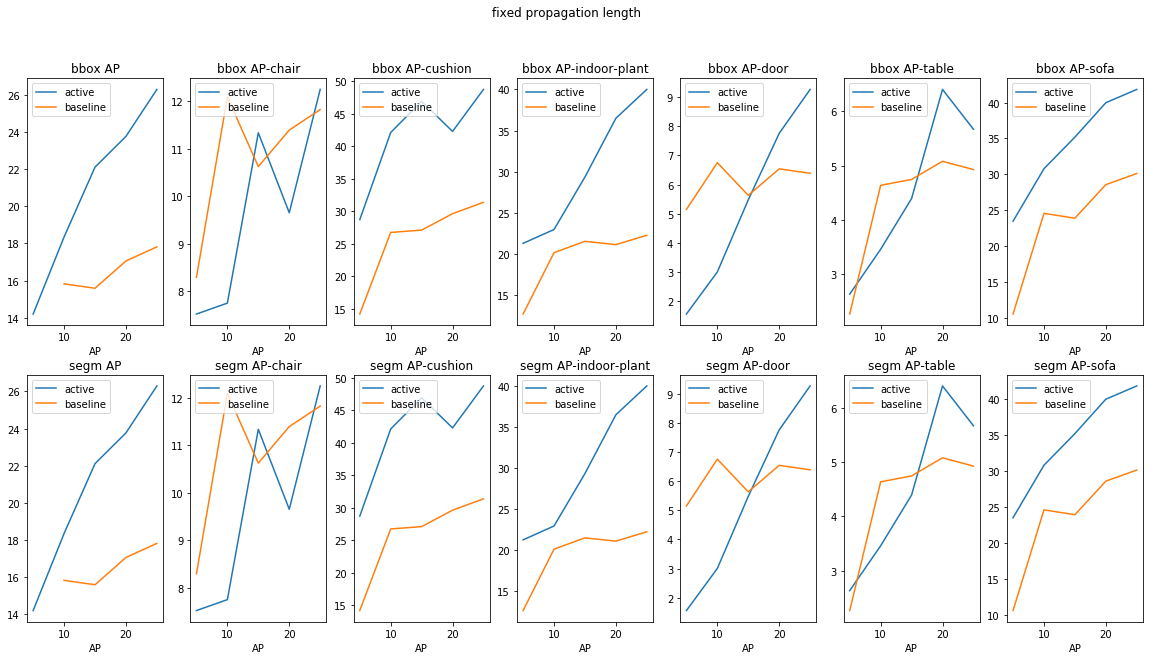

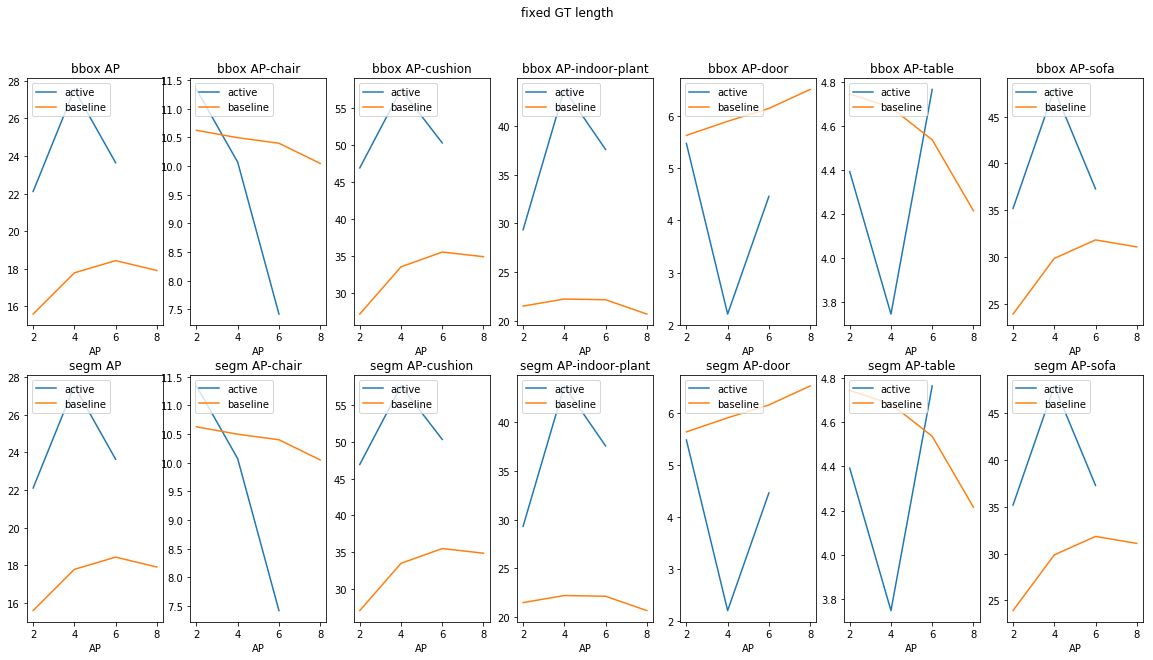

In [8]:
compare(
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24',
    '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/default/noise/09-09-2021/10:21:50', 
    getkey_pfix,
    'fixed propagation length',
    '#GT Frames',
    gts=[5,10,15,20,25],
    ps=[2],
    n=40,
    pref='activeonly'
)

compare(
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24',
    '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/default/noise/09-09-2021/10:21:50', 
    getkey_gtfix,
    'fixed GT length',
    'Propagation length',
    gts=[15],
    ps=[2,4,6,8],
    n=40,
    pref='activeonly'
)

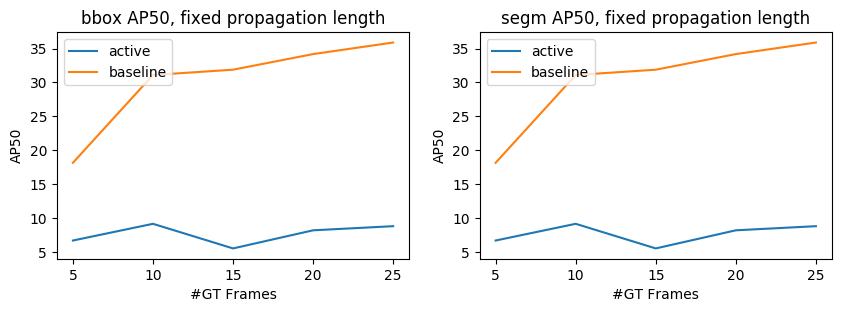

json.loads exception, skipping ('/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-10-2021/13:41:32/1/default/pred_label_gt5p2/all_results.txt', {'bbox': {'AP': 18.177412915630413, 'AP50': 36.28354873741289, 'AP75': 14.534407170935419, 'APs': 7.336800022121846, 'APm': 17.925181078597724, 'APl': 16.18498532164609, 'AP-chair': 13.549336241147097, 'AP-cushion': 29.734288418509585, 'AP-door': 2.656553891422681, 'AP-indoor-plant': 15.025014213697935, 'AP-sofa': 47.7434268868818, 'AP-table': 0.3558578421233754}, 'segm': {'AP': 18.671780583025615, 'AP50': 33.881126444417056, 'AP75': 19.831531888005095, 'APs': 9.072163406957765, 'APm': 19.647636014434323, 'APl': 15.55784177226936, 'AP-chair': 9.746690017222168, 'AP-cushion': 44.586710486807256, 'AP-door': 1.774557752103516, 'AP-indoor-plant': 11.556410209031236, 'AP-sofa': 44.36631503298951, 'AP-table': 0.0}})
json.loads exception, skipping ('/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straigh

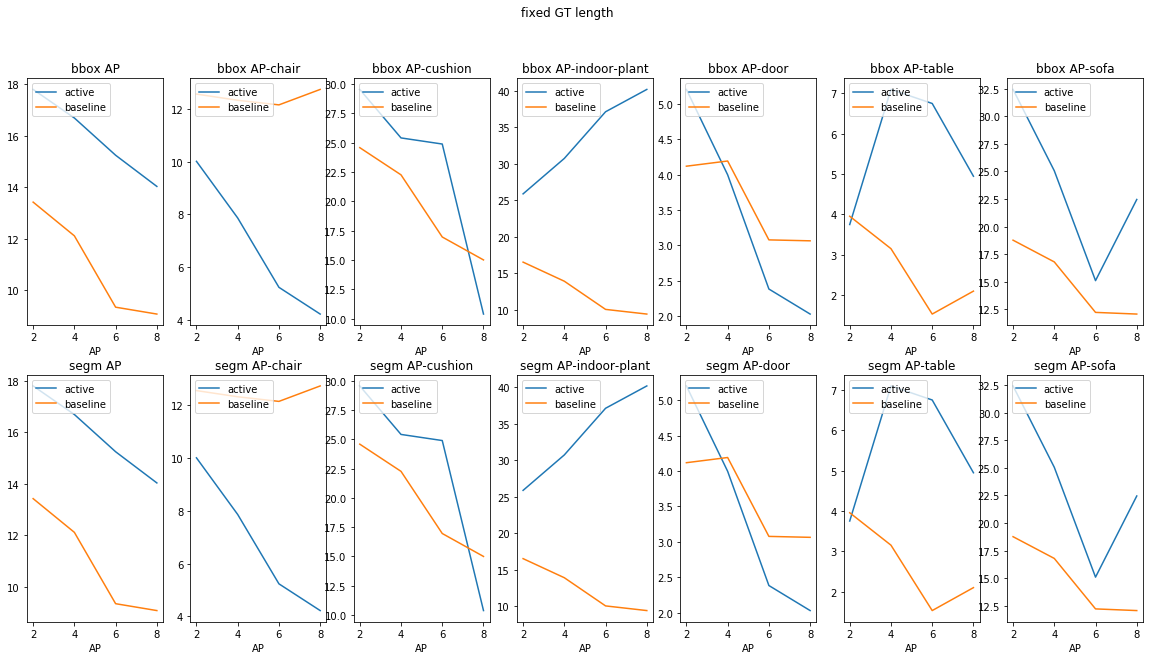

In [15]:
compare(
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-10-2021/13:41:32/',
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-09-2021/02:35:54',
    getkey_pfix,
    'fixed GT length',
    'Propagation length',
    gts=[5],
    ps=[2,4,6,8],
    n=100,
    pref='default',
)

# compare(
#     '/checkpoint/kavyasrinet/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/09:15:45', 
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-09-2021/02:35:54',
#     getkey_gtfix,
#     'fixed GT length',
#     'Propagation length',
#     gts=[5],
#     ps=[2,4,6,8],
#     n=100
# )

json.loads exception, skipping ('/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24/5/default/pred_label_gt5p2/all_results.txt', {'bbox': {'AP': 3.4159282048220656, 'AP50': 7.3289450707201205, 'AP75': 3.338075376396777, 'APs': 1.3156799883219894, 'APm': 3.681764426555261, 'APl': 4.493783410897442, 'AP-chair': 8.576108750903492, 'AP-cushion': 0.0, 'AP-door': 11.270265479693407, 'AP-indoor-plant': 0.0, 'AP-sofa': 0.0, 'AP-table': 0.6491949983354915}, 'segm': {'AP': 2.18526983393429, 'AP50': 3.7917727555830867, 'AP75': 2.043001421629148, 'APs': 0.0005112624083123547, 'APm': 1.45286183761382, 'APl': 4.423673747299158, 'AP-chair': 2.2276833409185604, 'AP-cushion': 0.0, 'AP-door': 10.88393566268718, 'AP-indoor-plant': 0.0, 'AP-sofa': 0.0, 'AP-table': 0.0}})
json.loads exception, skipping ('/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24/5/default/pred_label_gt5p4/all_results.txt', {'bbox': {'AP

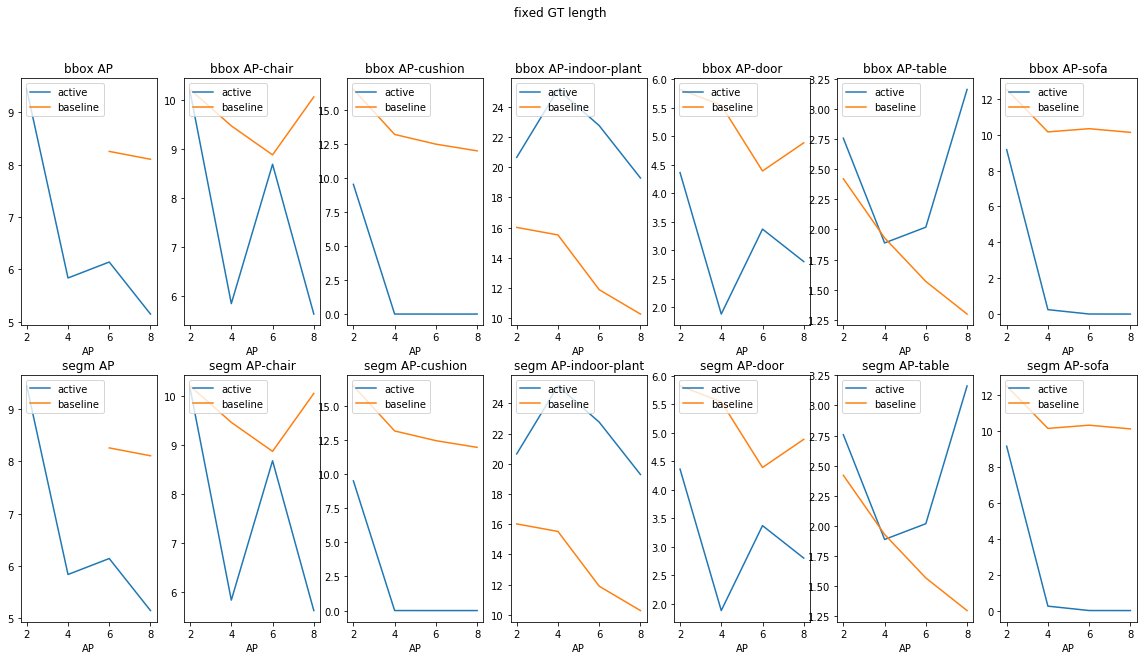

In [5]:
compare(
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24',
    '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/default/noise/09-09-2021/10:21:50', 
    getkey_gtfix,
    'fixed GT length',
    'Propagation length',
    gts=[5],
    ps=[2,4,6,8],
    n=100,
    pref='default',
)